In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2022-05-16 16:31:57--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2022-05-16 16:31:58--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48687 (48K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.55K  --.-KB/s    in 0.002s  

2022-05-16 16:31:58 (19.8 MB/s) - ‘thinkdsp.py’ saved [48687/48687]



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Упражнение 1

На сайте Soft Murmur можно послушать множество природных источников шума, включая дождь, волны, ветер, и др. На веб-странице http://asoftmurmur.com/about/ приведен пеечень записей; большинство из них хранится на http://freesound.org.

Скачайте некоторые из этих файлов и вычислите спетры каждого сигнала. Похож ли их спектр мощности на белый, розовый или броуновский шум? Как спектр меняется во времени?

## Решение

Возьмем записи природных источников шума из репозитория автора, а именно волны в океане:


In [3]:
if not os.path.exists('132736__ciccarelli__ocean-waves.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/132736__ciccarelli__ocean-waves.wav

--2022-05-16 16:35:11--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/132736__ciccarelli__ocean-waves.wav
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/132736__ciccarelli__ocean-waves.wav [following]
--2022-05-16 16:35:11--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/132736__ciccarelli__ocean-waves.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14286332 (14M) [application/octet-stream]
Saving to: ‘132736__ciccarelli__ocean-waves.wav’

132736__ciccarelli_ 100%[===================>]  13.62M  --.-KB/s    in 0.08s   

2022-05

In [4]:
from thinkdsp import read_wave

wave = read_wave('132736__ciccarelli__ocean-waves.wav')
wave.make_audio()

Output hidden; open in https://colab.research.google.com to view.

Выберем короткий сегмент:

In [5]:
segment = wave.segment(start=1.5, duration=1.0)
segment.make_audio()

Его спектр:

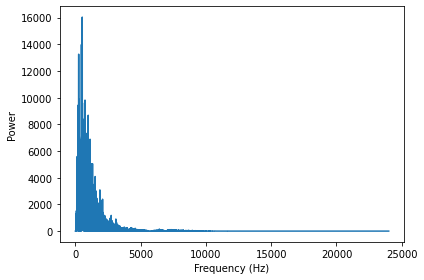

In [6]:
spectrum = segment.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

Амплитуда падает с частотой, так что это может быть красный или розовый шум. Мы можем проверить это, посмотрев на спектр мощности в логарифмической шкале.

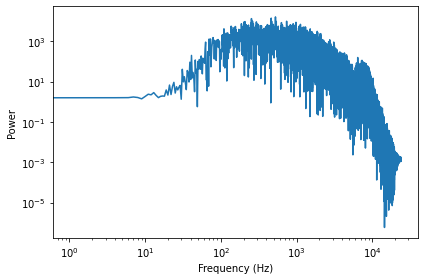

In [7]:
spectrum.plot_power()

loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Frequency (Hz)',
         ylabel='Power', 
         **loglog)

Эта структура с увеличением, а затем уменьшением амплитуды, по-видимому, обычна для естественных источников шума.

Выше f = 10 ^ 3 он может падать линейно, но мы не можем точно сказать.

Чтобы увидеть, как спектр меняется со временем, выберем другой сегмент:

In [8]:
segment2 = wave.segment(start=2.5, duration=1.0)
segment2.make_audio()

График двух спектров:

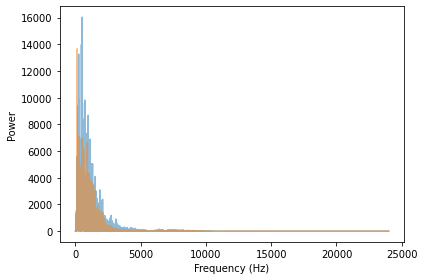

In [9]:
spectrum2 = segment2.make_spectrum()

spectrum.plot_power(alpha=0.5)
spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

Они же на логарифмической шкале:

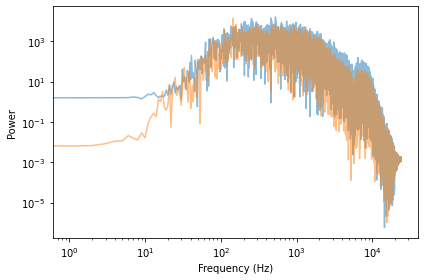

In [10]:
spectrum.plot_power(alpha=0.5)
spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Таким образом, структура кажется неизменной во времени.

Мы также можем посмотреть на спектрограмму:

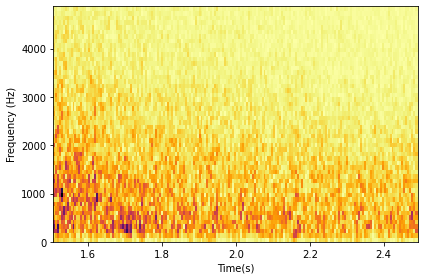

In [11]:
segment.make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

В пределах этого сегмента общая амплитуда падает, но смесь частот кажется постоянной.

## Упражнение 2

В шумовом сигнале частостный состав меняется во времени. На большой интервале мощность на всех частотах одинакова, а на коротком мощность на каждой частоте случайна.

Для оценки долговременной средней мощности на каждой частоте можно разорвать сигнал на сегменты, вычислить спектр мощности для каждого сегмента, а затем найти среднее по сегментам. Об этом алгормитре можно прочитать подробнее на странице http://en.wikipedia.org/wiki/Bartlett's_method.

Реализуйте метод Бартлетта и исользуйте его для оценки спектра мощности шумового сигнала.

## Решение

Метод Бартлетта:


In [12]:
from thinkdsp import Spectrum

def bartlett_method(wave, seg_length=512, win_flag=True):
    """Estimates the power spectrum of a noise wave.
    
    wave: Wave
    seg_length: segment length
    """
    # make a spectrogram and extract the spectrums
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()
    
    # extract the power array from each spectrum
    psds = [spectrum.power for spectrum in spectrums]
    
    # compute the root mean power (which is like an amplitude)
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    
    # make a Spectrum with the mean amplitudes
    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

`bartlett_method` строит спектрограмму и извлекает `spec_map`, которая сопоставляет время с объектами Spectrum. Он вычисляет PSD для каждого спектра, суммирует их и помещает результаты в объект Spectrum.

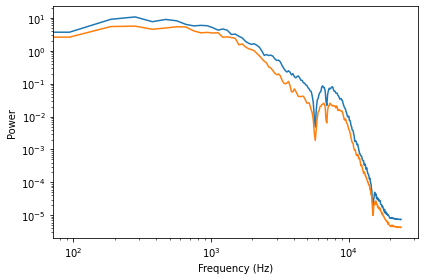

In [13]:
psd = bartlett_method(segment)
psd2 = bartlett_method(segment2)

psd.plot_power()
psd2.plot_power()

decorate(xlabel='Frequency (Hz)', 
         ylabel='Power', 
         **loglog)

Теперь мы можем более четко увидеть взаимосвязь между мощностью и частотой. Это не просто линейная зависимость, но она постоянна для разных сегментов, даже в таких деталях, как метки около 5000 Гц, 6000 Гц и выше 10 000 Гц.

## Упражнение 3

На веб-странице https://www.coindesk.com/price/bitcoin можно скачать в виде CSV-файла исторические данные о ежедневной цене BitCoin. Откройте этот файл и вычислите спектр цен BitCoin как функцию времени. Похоже ли это на белый, розовый или броуновский шум?

## Решение

Скачаем данные о цене BitCoin:

In [14]:
if not os.path.exists('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv

--2022-05-16 16:49:20--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv [following]
--2022-05-16 16:49:20--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143622 (140K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 140.26K  --.-KB/s    in 0.02

In [15]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv', 
                 parse_dates=[0])
df

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.654990,124.304660,124.751660,122.563490
1,BTC,2013-10-02,125.455000,123.654990,125.758500,123.633830
2,BTC,2013-10-03,108.584830,125.455000,125.665660,83.328330
3,BTC,2013-10-04,118.674660,108.584830,118.675000,107.058160
4,BTC,2013-10-05,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...,...
2354,BTC,2020-03-22,5884.340133,6187.042146,6431.873162,5802.553402
2355,BTC,2020-03-23,6455.454688,5829.352511,6620.858253,5694.198299
2356,BTC,2020-03-24,6784.318011,6455.450650,6863.602196,6406.037439
2357,BTC,2020-03-25,6706.985089,6784.325204,6981.720386,6488.111885


In [16]:
ys = df['Closing Price (USD)']
ts = df.index

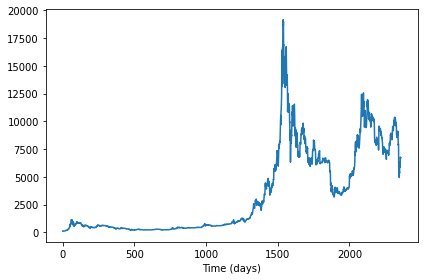

In [17]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)')

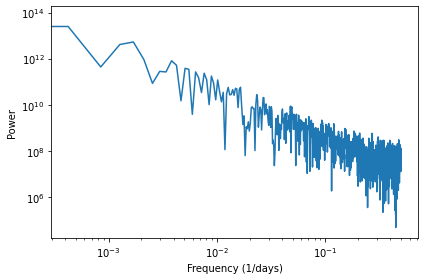

In [18]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (1/days)',
         ylabel='Power', 
         **loglog)

In [19]:
spectrum.estimate_slope()[0]

-1.7332540936758951

Красный шум должен иметь наклон -2. Наклон этой PSD близок к 1,7, поэтому трудно сказать, следует ли считать это красным шумом или следует говорить о разновидности розового шума.

## Упражнение 4

Счетчик Гейгера — это прибор, который регистрирует радиацию. Когда ионизирующая частица попадает на детектор, он генерирует всплеск тока. Общий вывод в определенный момент времени можно смоделировать как некоррелированный шум Пуассона (UP), где каждая выборка представляет собой случайную величину из распределения Пуассона, которая соответствует количеству частиц, обнаруженных в течение интервала.

Напишите класс с именем `UncorrelatedPoissonNoise`, который наследуется от `_Noise` и предоставляет `evaluate`. Он должен использовать `np.random.poisson` для генерации случайных значений из распределения Пуассона. Параметр этой функции, lam, представляет собой среднее число частиц в течение каждого интервала. Вы можете использовать атрибут `amp`, чтобы указать `lam`. Например, если частота кадров равна 10 кГц, а amp равно 0,001, мы ожидаем около 10 «кликов» в секунду.

Создайте около секунды шума UP и послушайте его. Для низких значений «ампер», например 0,001, это должно звучать как счетчик Гейгера. Для более высоких значений это должно звучать как белый шум. Вычислите и начертите спектр мощности, чтобы увидеть, похож ли он на белый шум.

## Решение

In [20]:
from thinkdsp import Noise

class UncorrelatedPoissonNoise(Noise):
    """Represents uncorrelated Poisson noise."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Вот как это звучит при низких уровнях «радиации:.

In [21]:
amp = 0.001
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

Чтобы убедиться, что все работает, мы сравним ожидаемое количество частиц и фактическое количество:

In [22]:
expected = amp * framerate * duration
actual = sum(wave.ys)
print(expected, actual)

10.0 14


Вейв:

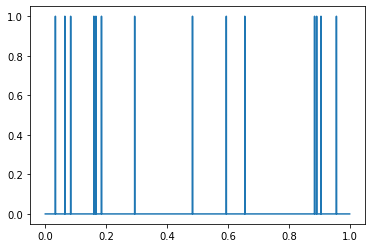

In [23]:
wave.plot()

А вот его спектр мощности в логарифмической шкале.

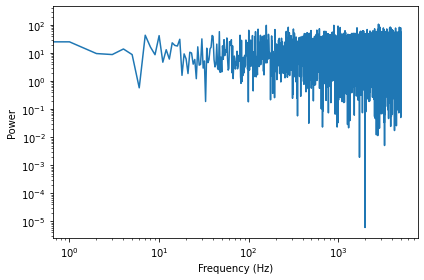

In [24]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Похоже на белый шум, и наклон близок к 0.

In [25]:
spectrum.estimate_slope().slope

0.0015346589955882162

С более высокой скоростью прибытия это больше похоже на белый шум:

In [26]:
amp = 1
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

Это больше похоже на сигнал:

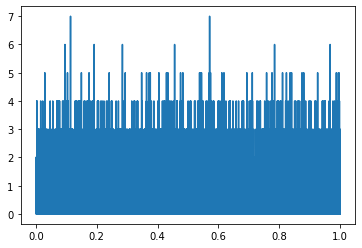

In [27]:
wave.plot()

И спектр сходится на гауссовом шуме.

In [28]:
import matplotlib.pyplot as plt

def normal_prob_plot(sample, fit_color='0.8', **options):
    """Makes a normal probability plot with a fitted line.

    sample: sequence of numbers
    fit_color: color string for the fitted line
    options: passed along to Plot
    """
    n = len(sample)
    xs = np.random.normal(0, 1, n)
    xs.sort()
    
    ys = np.sort(sample)
    
    mean, std = np.mean(sample), np.std(sample)
    fit_ys = mean + std * xs
    plt.plot(xs, fit_ys, color='gray', alpha=0.5, label='model')

    plt.plot(xs, ys, **options)

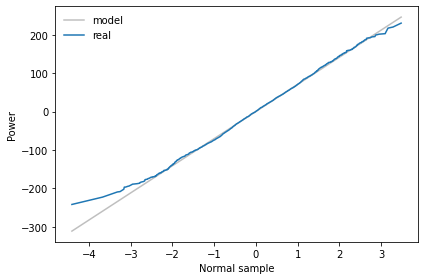

In [29]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0

normal_prob_plot(spectrum.real, label='real')
decorate(xlabel='Normal sample',
        ylabel='Power')

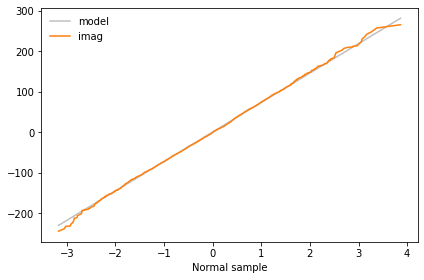

In [30]:
normal_prob_plot(spectrum.imag, label='imag', color='C1')
decorate(xlabel='Normal sample')

## Упражнение 5

В этой главе алгоритм для генерации розового шума концептуально простой, но затратный. Существуют более эффективные варианты, например алгоритм Voss-McCartney. Изучите этот способ, реализуейте его, вычислите спектр результата и убедитесь, что соотношение между мощностью и частотой соответствующее.

## Решение

Основная идея этого алгоритма состоит в том, чтобы сложить несколько последовательностей случайных чисел, которые обновляются с разной частотой дискретизации. Первый источник должен обновляться на каждом временном шаге; второй источник через каждый второй временной шаг, третий источник через каждый четвертый шаг и так далее.

В исходном алгоритме обновления равномерно распределены. В альтернативе, предложенной на http://www.firstpr.com.au/dsp/pink-noise/, они расположены случайным образом.

Реализация начинается с массива с одной строкой на временной шаг и одним столбцом для каждого из источников белого шума. Изначально первая строка и первый столбец являются случайными, а остальная часть массива — Nan.

In [31]:
nrows = 100
ncols = 5

array = np.empty((nrows, ncols))
array.fill(np.nan)
array[0, :] = np.random.random(ncols)
array[:, 0] = np.random.random(nrows)
array[0:6]

array([[0.18244021, 0.91284354, 0.6845662 , 0.39657208, 0.28113689],
       [0.67095029,        nan,        nan,        nan,        nan],
       [0.69308968,        nan,        nan,        nan,        nan],
       [0.73290367,        nan,        nan,        nan,        nan],
       [0.07327865,        nan,        nan,        nan,        nan],
       [0.58349525,        nan,        nan,        nan,        nan]])

Следующим шагом является выбор мест, где меняются случайные источники. Если количество строк равно n, количество изменений в первом столбце равно n, число во втором столбце в среднем равно n/2, число в третьем столбце равно n/4 в среднем и т.д.

Таким образом, общее количество изменений в матрице в среднем составляет 2n; поскольку n из них находятся в первом столбце, остальные n находятся в остальной части матрицы.

Чтобы разместить оставшиеся n изменений, мы генерируем случайные столбцы из геометрического распределения с p=0,5. Если мы генерируем значение, выходящее за пределы, мы устанавливаем его равным 0 (чтобы первый столбец получал дополнительные значения).

In [32]:
p = 0.5
n = nrows
cols = np.random.geometric(p, n)
cols[cols >= ncols] = 0
cols

array([1, 2, 1, 2, 4, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1,
       1, 3, 2, 1, 2, 2, 3, 1, 1, 2, 4, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1,
       1, 1, 1, 3, 2, 1, 2, 1, 4, 1, 2, 1, 3, 1, 1, 1, 4, 3, 2, 1, 1, 3,
       1, 3, 1, 1, 2, 4, 2, 3, 4, 1, 2, 2, 1, 1, 1, 4, 2, 1, 1, 4, 0, 2,
       1, 1, 0, 1, 1, 1, 4, 1, 3, 1, 1, 4])

В каждом столбце мы выбираем случайную строку из равномерного распределения. В идеале мы бы выбрали без замены, но с заменой выбрать быстрее и проще.

In [33]:
rows = np.random.randint(nrows, size=n)
rows

array([ 2, 56, 34, 97, 95, 84, 52, 64,  7, 49,  1, 77, 16,  3, 74, 20, 23,
       83, 70, 35, 71, 16, 87, 21, 74,  4, 61, 14, 52, 57, 62, 27, 46, 52,
       87, 94, 53, 94, 46, 70, 27, 69, 19,  2, 43,  3, 12, 72, 73, 45, 11,
       57, 49, 21,  6, 98,  4, 34, 24, 88, 46, 94, 66, 55, 23, 75, 41,  7,
       89, 58, 50, 30, 81, 31, 52, 87, 32, 56, 33, 85, 57, 68, 30, 93, 11,
       70, 89, 41,  3, 26, 33, 49, 48, 28, 59, 61, 68, 11, 13, 14])

Теперь мы можем поместить случайные значения в каждую из точек изменения.

In [34]:
array[rows, cols] = np.random.random(n)
array[0:6]

array([[0.18244021, 0.91284354, 0.6845662 , 0.39657208, 0.28113689],
       [0.57522677,        nan,        nan,        nan,        nan],
       [0.69308968, 0.12265784,        nan,        nan,        nan],
       [0.73290367, 0.58935741,        nan,        nan,        nan],
       [0.07327865, 0.68629943,        nan, 0.61707088,        nan],
       [0.58349525,        nan,        nan,        nan,        nan]])

Затем мы хотим выполнить удержание нулевого порядка, чтобы заполнить NaN. NumPy этого не делает, но Pandas делает. Создаем DataFrame:

In [35]:
df = pd.DataFrame(array)
df.head()

,0,1,2,3,4
0,0.182440,0.912844,0.684566,0.396572,0.281137
1,0.575227,NaN,NaN,NaN,NaN
2,0.693090,0.122658,NaN,NaN,NaN
3,0.732904,0.589357,NaN,NaN,NaN
4,0.073279,0.686299,NaN,0.617071,NaN


А затем используем `fillna` вдоль столбцов.

In [36]:
filled = df.fillna(method='ffill', axis=0)
filled.head()

,0,1,2,3,4
0,0.182440,0.912844,0.684566,0.396572,0.281137
1,0.575227,0.912844,0.684566,0.396572,0.281137
2,0.693090,0.122658,0.684566,0.396572,0.281137
3,0.732904,0.589357,0.684566,0.396572,0.281137
4,0.073279,0.686299,0.684566,0.617071,0.281137


Наконец, мы складываем строки.

In [37]:
total = filled.sum(axis=1)
total.head()

0    2.457559
1    2.850345
2    2.178023
3    2.684536
4    2.342352
dtype: float64

Если мы поместим результаты в волну, вот как это будет выглядеть:

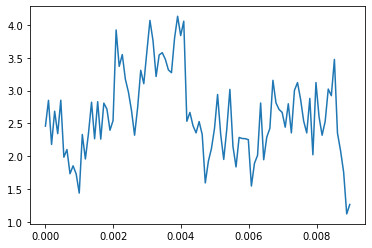

In [38]:
wave = Wave(total.values)
wave.plot()

Вот весь процесс в функции:

In [39]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

Чтобы проверить это, сгенерируем 11025 значений:

In [40]:
ys = voss(11025)
ys

array([6.81286206, 7.28743416, 6.7690575 , ..., 8.02290628, 7.55851426,
       8.28463856])

И переведем их в волну:

In [41]:
wave = Wave(ys)
wave.unbias()
wave.normalize()

Вот как это выглядит:

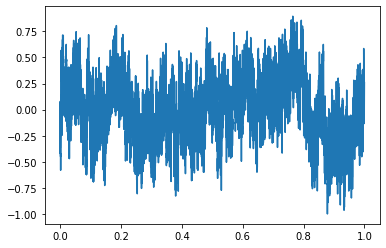

In [42]:
wave.plot()

Как и ожидалось, он больше похож на случайное блуждание, чем белый шум, но выглядит более случайным, чем красный шум.

Вот как это звучит:

In [43]:
wave.make_audio()

Спектр мощности:

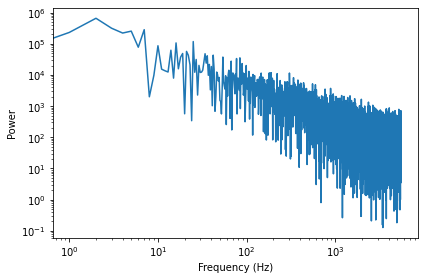

In [44]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Расчетный наклон близок к -1.

In [45]:
spectrum.estimate_slope().slope

-1.0077183855052603

Мы можем получить спектр средней мощности лучше, сгенерировав более длинную выборку:

In [46]:
seg_length = 64 * 1024
iters = 100
wave = Wave(voss(seg_length * iters))
len(wave)

6553600

И используем метод Барлетта для вычисления среднего.

In [47]:
spectrum = bartlett_method(wave, seg_length=seg_length, win_flag=False)
spectrum.hs[0] = 0
len(spectrum)

32769

Это довольно близко к прямой линии с некоторой кривизной на самых высоких частотах.

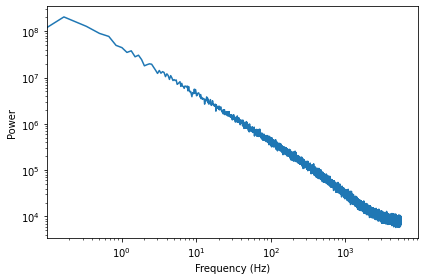

In [48]:
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

И наклон близок к -1.

In [49]:
spectrum.estimate_slope().slope

-1.002172884952657